# Label Propagaton Helpers

This notebook has helpers for the following:
* ### Pre label propagation
  * Takes in a COCO json and converts *.npy segmentation maps for each image collected from Replica to *.png to feed to label propagation techniques.
* ### Insert your own label propagation technique here, to take in segmentation maps in png and output png
* ### Post label propagation
  * Converts *.png segmentation maps output by label propagation into *.npy segmentation maps
  * Outputs metrics (MSE) to evaluate the quality of label propagation, including visualizations 


In [164]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from pycocotools.coco import COCO
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import png

# Pre label propagation
convert *.npy to *.png

In [171]:
train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'
gt_seg_dir =  '/home/locobotm/AVD/habitat_data_with_seg/seg/' # folder with GT segmentation maps collected from Replica
out_seg_dir = '/home/locobotm/AVD/habitat_data_with_seg/prop_3/' # dumps *.pngs here

In [173]:
coco = COCO(train_json)
to_propogate = coco.getImgIds()
print("{} images to prepare".format(len(to_propogate)))

if not os.path.exists(out_seg_dir):
    print("Creating directory {}".format(out_seg_dir))
    os.makedirs(out_seg_dir)

# Copy *.npy to *.png
for x in to_propogate:
    filename = "{:05d}".format(x)
    png_f = os.path.join(out_seg_dir + filename + '.png')
    semantic_obs = np.load(os.path.join(gt_seg_dir, filename + '.npy')).astype(np.uint8)    
    semantic_img = png.from_array(semantic_obs, 'L').save(png_f)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
120 images to prepare


# Do label propagation on `out_seg_dir` images

# Post label propagation
  * Converts *.png segmentation maps output by label propagation into *.npy segmentation maps
  * Outputs metrics (MSE) to evaluate the quality of label propagation, including visualization

In [174]:
prop_seg_dir =  '/home/locobotm/semantic-segmentation/masks/demoVideo/rgb/' # Label propagated segmentation maps
out_npy_dir = '/home/locobotm/AVD/habitat_data_with_seg/seg_p/' # dump *.npy segmentation maps here

In [176]:
if not os.path.exists(out_npy_dir):
    print("Creating folder {}".format(out_npy_dir))
    os.makedirs(out_npy_dir)

prop_fs = [x for x in os.listdir(prop_seg_dir)]
print("Found {} segmentation maps.".format(len(aug_fs)))

for x in prop_fs:
    img = Image.open( os.path.join(prop_seg_dir, x))
    filename = x.split('.')[0] +'.npy'
    data = np.array(img, dtype='uint8')
    np.save(os.path.join(out_npy_dir, filename), data)

print("Dumped npy segmentation maps at {}".format(out_npy_dir))

Found 240 segmentation maps.
Dumped npy segmentation maps at /home/locobotm/AVD/habitat_data_with_seg/seg_p/


## Evaluate label propagated segmentation maps
MSE (`out_npy_dir`, `gt_seg_dir`)

MSE 374.5859680175781, over 120 frames
Display highest 5 MSE segm maps ... 


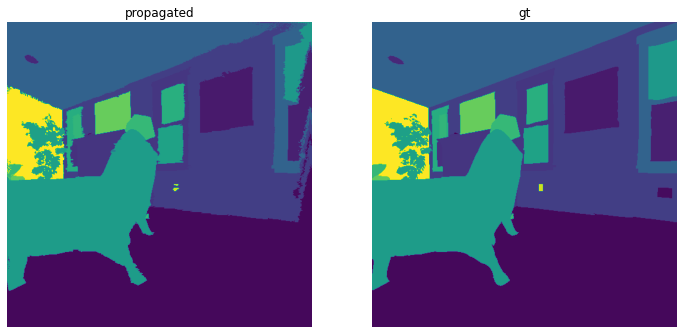

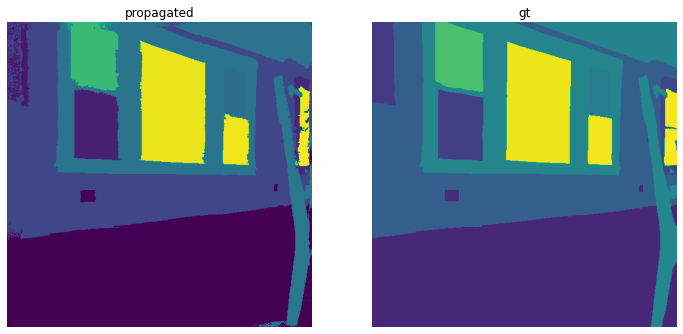

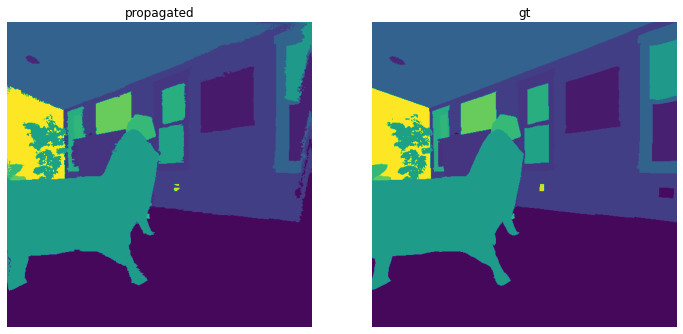

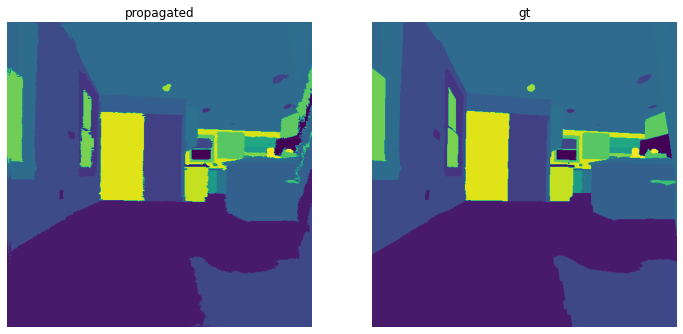

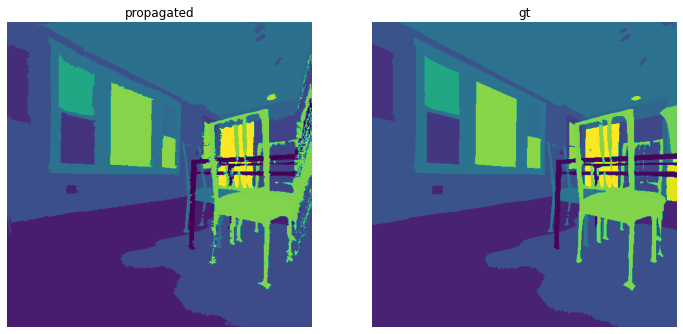

In [189]:
prop_seg = os.listdir(out_npy_dir)
mse = {}
cnt = 0
for x in prop_seg:
    img = int(x.split('.')[0])
    if img not in to_propogate:
        cnt += 1
        prop_data = np.load(os.path.join(out_npy_dir) + x).astype(np.uint8)
        gt_data = np.load(os.path.join(gt_seg_dir) + x).astype(np.uint8)
        mse[img] = (np.square(prop_data-gt_data)).mean(axis=None)

print("MSE {}, over {} frames".format(sum(mse.values()), cnt))

print("Display highest 5 MSE segm maps ... ")
for k, v in sorted(mse.items(), key = lambda item: item[1], reverse=True)[:5]:
    filename = "{:05d}.npy".format(k)
    prop_data = np.load(os.path.join(out_npy_dir) + filename).astype(np.uint8)
    gt_data = np.load(os.path.join(gt_seg_dir) + filename).astype(np.uint8)
    
    plt.figure(figsize=(12 , 8))
    ax = plt.subplot(1, 2, 1)
    ax.axis('off')
    ax.set_title('propagated')
    plt.imshow(prop_data)

    ax = plt.subplot(1, 2, 2)
    ax.axis('off')
    ax.set_title("gt")
    plt.imshow(gt_data)

    plt.show()        
